In [1]:
from typing import TypedDict

from browser import ChromeBrowser
from browser.search.web import BraveBrowser
from generalist.agents.core import CapabilityPlan
from generalist.tools.data_model import ContentResource, ShortAnswer, Task

from dotenv import load_dotenv
load_dotenv()

class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # Clues, findings and answers to the previous subtasks
    # Used to execute a capability plan step given already found information
    context: str  
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: CapabilityPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str

MAX_STEPS = 5
BRAVE_SEARCH = BraveBrowser(browser=ChromeBrowser(), session_id="deep_web_search")

/Users/maksim.rostov/pdev/freelectron/free-generalist/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
sh: pidof: command not found


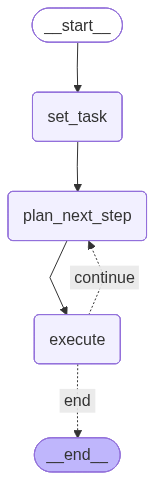

In [2]:
import json
from generalist.agents.core import AgentCapabilityDeepWebSearch, AgentCapabilityUnstructuredDataProcessor, \
    AgentCapabilityCodeWriterExecutor, AgentCapabilityAudioProcessor, AgentCapabilityOutput
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer
from langgraph.graph import StateGraph, START, END


def init_state(ask: str, resources: list[ContentResource] | None = None) -> ExecutionState:
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context="",
        answers=list(),
        resources=resources if resources else [],
    )

def set_task(state: ExecutionState) -> ExecutionState:
    question_task = state["ask"]
    resources = state["resources"]
    task_plan_response = create_plan(question_task, resources)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    identified_resource = result.get("resource", None)
    if identified_resource:
        task_resource = ContentResource(
            provided_by="user",
            content=identified_resource.get("content", None),
            link=identified_resource.get("link", None),
            metadata={},
        )
        state["resources"].append(task_resource)
    state["task"] = task

    state["step"] = 0
    return state

def evaluate_task_completion(state: ExecutionState) -> str:
    short_answer = construct_short_answer(
        state["task"].objective,
        state["context"]
    )

    # Early stopping if answer exists
    if short_answer.answered:
        return "end"

    # Early stopping if maximum number of steps reached
    if state['step'] > MAX_STEPS:
        return "end"

    return "continue"

def plan_next_step(state: ExecutionState) -> ExecutionState:
    # Automatically determine which step to execute based on context
    capability_plan_json = determine_capabilities(
        task=state["task"],
        context=state["context"]
    )

    state["capability_plan"] = CapabilityPlan.from_json(capability_plan_json)
    return state

def execute(state: ExecutionState) -> ExecutionState:
    activity, capability = state["capability_plan"].subplan[0]
    output = AgentCapabilityOutput(activity)
    capability_agent = capability(activity)

    if capability is AgentCapabilityDeepWebSearch:
        # Reinitiate the agent since it might need browser
        capability_agent = capability(activity=activity, search_browser=BRAVE_SEARCH)
        output = capability_agent.run()
    elif capability is AgentCapabilityUnstructuredDataProcessor:
        output = capability_agent.run(state["resources"])
    elif capability is AgentCapabilityCodeWriterExecutor:
        output = capability_agent.run(state["resources"])
    elif capability is AgentCapabilityAudioProcessor:
        output = capability_agent.run(state["resources"])
    else:
        print("DEBUG | run_capability | Call to unidentified agent: ", capability)

    if output.answers:
        state["answers"].extend(output.answers)
    if output.resources:
        state["resources"].extend(output.resources)

    # Update context with step results
    state["context"] += f"\nStep {state['step']}: {state['answers']}"
    state["step"] += 1

    return state


workflow = StateGraph(state_schema=ExecutionState)

workflow.add_node("set_task", set_task)
workflow.add_node("plan_next_step", plan_next_step)
workflow.add_node("execute", execute)

workflow.add_edge(START, "set_task")
workflow.add_edge("set_task", "plan_next_step")
workflow.add_edge("plan_next_step", "execute")
workflow.add_conditional_edges(
    "execute",
    evaluate_task_completion,
    {
        "continue": "plan_next_step",
        "end": END,
    }
)

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [3]:
from generalist.models.core import MLFlowLLMWrapper
from generalist.tools import planning, web_search, text_processing, code

# MONKEY PATCH THE LLM CALLS TO HAVE THE LOGGING IN STDOUT
planning.llm = MLFlowLLMWrapper(planning.llm) 
web_search.llm = MLFlowLLMWrapper(web_search.llm)
text_processing.llm = MLFlowLLMWrapper(text_processing.llm)
code.llm = MLFlowLLMWrapper(code.llm)

In [4]:
import os
import logging
from dotenv import load_dotenv

import mlflow
from huggingface_hub import snapshot_download
from datasets import load_dataset

logging.getLogger().setLevel(logging.INFO)
load_dotenv()

gaia_path = os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH")
data_dir = snapshot_download(local_dir=gaia_path,  local_files_only=True, repo_id="gaia-benchmark/GAIA", repo_type="dataset")

dataset = load_dataset(data_dir, "2023_level1", split="validation")
gaia_keys = ['task_id', 'Question', 'Level', 'Final answer', 'file_name', 'file_path', 'Annotator Metadata']

sosa_many_studio_albums_task_id = "8e867cd7-cff9-4e6c-867a-ff5ddc2550be"
running_to_the_moon_task_id = "e1fc63a2-da7a-432f-be78-7c4a95598703"
dr_who_season_9_eps_11_location_task_id = "4b6bb5f7-f634-410e-815d-e673ab7f8632"
calc_sales_xlsx_task_id = "7bd855d8-463d-4ed5-93ca-5fe35145f733"
just_running_python_task_id = "f918266a-b3e0-4914-865d-4faa564f1aef"
evaluation_tasks = [
    just_running_python_task_id,
    calc_sales_xlsx_task_id,
    # sosa_many_studio_albums_task_id,
    # running_to_the_moon_task_id,
]

results = []
dataset_questions = { sample["task_id"]:sample for sample in dataset }
for sample_task_id in evaluation_tasks:
    sample = dataset_questions[sample_task_id]
    [ print(k, "=", sample[k]) for k in gaia_keys]

    mlflow.langchain.autolog()                                                 # this is needed to register traces within the experiment
    experiment_name = f"gaia_{"_".join(sample["task_id"].split("-"))}"
    mlflow.set_experiment(experiment_name)
    mlflow.models.set_model(generalist_graph)
    logging.getLogger().setLevel(logging.INFO)

    experiment_url = mlflow.get_experiment_by_name(experiment_name)
    # mlflow.set_tracking_uri('http://localhost:5000')

    question = sample["Question"]
    resources = []
    if sample["file_path"]:
        resource = ContentResource(
            provided_by="user",
            content="file provided with the main task",
            link=os.path.join(os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH"), sample["file_path"]),
            metadata={"note":"the file is already in the list of available resources"}
        )
        print(resource.link)
        resources.append(resource)
    initial_state = init_state(question, resources=resources)
    final_state = generalist_graph.invoke(initial_state)
    answers = final_state["answers"]
    results.append((sample, {"answers":answers, "experiment_url": experiment_url}))

Returning existing local_dir `/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia` as remote repo cannot be accessed in `snapshot_download` (None).


task_id = f918266a-b3e0-4914-865d-4faa564f1aef
Question = What is the final numeric output from the attached Python code?
Level = 1
Final answer = 0
file_name = f918266a-b3e0-4914-865d-4faa564f1aef.py
file_path = 2023/validation/f918266a-b3e0-4914-865d-4faa564f1aef.py
Annotator Metadata = {'Steps': '1. Run the attached Python code', 'Number of steps': '1', 'How long did this take?': '30 seconds', 'Tools': '1. Python', 'Number of tools': '1'}
/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia/2023/validation/f918266a-b3e0-4914-865d-4faa564f1aef.py


2026-01-16 19:55:32,860 - generalist.tools.planning - INFO - - determine_capabilities -- Raw output: {
  "subplan": [
    {
      "activity": "Open and read the Python code from the specified file to understand its contents before execution.",
      "capability": "code_writing_execution"
    }
  ]
}
2026-01-16 19:55:41,525 - generalist.agents.core - INFO - - code_writing_execution -- EDA code to be executed:
```python
# The provided links do not match the file extensions we are looking for (.csv, .parquet, .xlsx)
print("No CSV, Parquet or Excel files found in the resources to process.")
```
2026-01-16 19:55:41,601 - generalist.agents.core - INFO - - code_writing_execution -- EDA code result:
--- STDOUT ---
No CSV, Parquet or Excel files found in the resources to process.


2026-01-16 19:55:57,360 - generalist.agents.core - INFO - - code_writing_execution -- Final code to be executed:
```python
# Since there are no CSV, Parquet or Excel files found in the resources to process,
# and no 

task_id = 7bd855d8-463d-4ed5-93ca-5fe35145f733
Question = The attached Excel file contains the sales of menu items for a local fast-food chain. What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places.
Level = 1
Final answer = 89706.00
file_name = 7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
file_path = 2023/validation/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
Annotator Metadata = {'Steps': '1. Open the attached file.\n2. Read the columns representing different menu items. Note that they all appear to be food except for the “soda” column.\n3. Write a function to sum the relevant columns.\n4. Ensure the answer follows the specified formatting.', 'Number of steps': '4', 'How long did this take?': '5 minutes', 'Tools': '1. Excel\n2. Calculator', 'Number of tools': '2'}
/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia/2023/validation/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx


2026-01-16 19:58:29,631 - generalist.tools.planning - INFO - - determine_capabilities -- Raw output: {
  "subplan": [
    {
      "activity": "Open and process the provided Excel file to identify food item sales columns, sum up their values, and exclude any drink-related sales data.",
      "capability": "code_writing_execution"
    }
  ]
}
2026-01-16 19:58:56,925 - generalist.agents.core - INFO - - code_writing_execution -- EDA code to be executed:
```python
print("Loading '/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia/2023/validation/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx' ")
import pandas as pd

# Load the Excel file
xlsx_file = pd.ExcelFile('/Users/maksim.rostov/pdev/freeelectron/free-generalist/evaluation/gaia/2023/validation/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx')

# Print the sheet names in the Excel file
print("Found sheets:", xlsx_file.sheet_names)

# Assuming we are interested in the first sheet, load it into a DataFrame
sheet_name = xlsx_file.s